In [ ]:
!pip install torch
!pip install salesforce-lavis
!pip install transformers

In [ ]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from transformers import AutoProcessor, AutoModelForCausalLM
from huggingface_hub import hf_hub_download

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_blip_vqa2, vis_processors_blip_vqa2, txt_processors_blip_vqa2 = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device)
model_blip_okvqa, vis_processors_blip_okvqa, txt_processors_blip_okvqa = load_model_and_preprocess(name="blip_vqa", model_type="okvqa", is_eval=True, device=device)
model_blip_aokvqa, vis_processors_blip_aokvqa, txt_processors_blip_aokvqa = load_model_and_preprocess(name="blip_vqa", model_type="aokvqa", is_eval=True, device=device)
model_albef_vqa2, vis_processors_albef_vqa2, txt_processors_albef_vqa2 = load_model_and_preprocess(name="albef_vqa", model_type="vqav2", is_eval=True, device=device)

100%|██████████| 1.35G/1.35G [00:16<00:00, 89.1MB/s]
100%|██████████| 4.04G/4.04G [00:52<00:00, 82.0MB/s]
100%|██████████| 4.04G/4.04G [01:19<00:00, 54.8MB/s]


100%|██████████| 4.33G/4.33G [02:15<00:00, 34.2MB/s]


# Single Instance Run

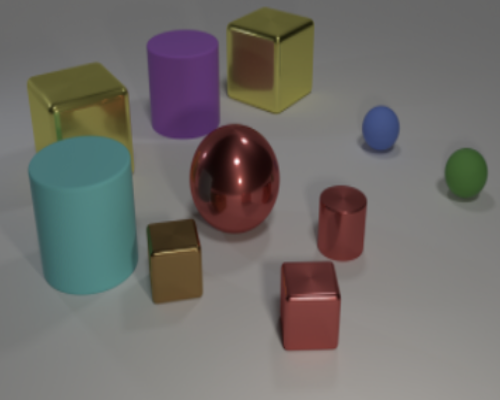

In [ ]:
raw_image = Image.open("/content/sample.png").convert("RGB")
display(raw_image.resize((500, 400)))
question = "How many cubes are there?"
answer_candidates = ["1", "2", "3", "4"]

In [ ]:
image_blip_vqa2 = vis_processors_blip_vqa2["eval"](raw_image).unsqueeze(0).to(device)
image_blip_okvqa = vis_processors_blip_okvqa["eval"](raw_image).unsqueeze(0).to(device)
image_blip_aokvqa = vis_processors_blip_aokvqa["eval"](raw_image).unsqueeze(0).to(device)
image_albef_vqa2 = vis_processors_albef_vqa2["eval"](raw_image).unsqueeze(0).to(device)

In [ ]:
processor_vilt = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model_vilt = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [ ]:
processor_git_vqav2 = AutoProcessor.from_pretrained("microsoft/git-base-vqav2")
model_git_vqav2 = AutoModelForCausalLM.from_pretrained("microsoft/git-base-vqav2")

In [ ]:
processor_gitl_vqav2 = AutoProcessor.from_pretrained("microsoft/git-large-vqav2")
model_gitl_vqav2 = AutoModelForCausalLM.from_pretrained("microsoft/git-large-vqav2")

In [ ]:
question_blip_vqa2 = txt_processors_blip_vqa2["eval"](question)
question_blip_okvqa = txt_processors_blip_okvqa["eval"](question)
question_blip_aokvqa = txt_processors_blip_aokvqa["eval"](question)
question_albef_vqa2 = txt_processors_albef_vqa2["eval"](question)

samples_blip_vqa2 = {"image": image_blip_vqa2, "text_input": question_blip_vqa2}
samples_blip_okvqa = {"image": image_blip_okvqa, "text_input": question_blip_okvqa}
samples_blip_aokvqa = {"image": image_blip_aokvqa, "text_input": question_blip_aokvqa}
samples_albef_vqa2 = {"image": image_albef_vqa2, "text_input": question_albef_vqa2}

In [ ]:
# blip vqav2
model_blip_vqa2.predict_answers(samples_blip_vqa2, answer_list=answer_candidates, inference_method="rank")[0]

'4'

In [ ]:
# blip okvqa
model_blip_okvqa.predict_answers(samples_blip_okvqa, answer_list=answer_candidates, inference_method="rank")[0]

'4'

In [ ]:
# blip aokvqa
model_blip_aokvqa.predict_answers(samples_blip_aokvqa, answer_list=answer_candidates, inference_method="rank")[0]

'4'

In [ ]:
# albef vqav2
model_albef_vqa2.predict_answers(samples_albef_vqa2, answer_list=answer_candidates, inference_method="rank")[0]

'3'

In [ ]:
# 3129 answer choices over vqav2
encoding = processor_vilt(raw_image, question, return_tensors="pt")
outputs = model_vilt(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()

In [ ]:
# vilt vqav2
model_vilt.config.id2label[idx]

'12'

In [ ]:
pixel_values = processor_git_vqav2(images=raw_image, return_tensors="pt").pixel_values
input_ids = processor_git_vqav2(text=question, add_special_tokens=False).input_ids
input_ids = [processor_git_vqav2.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

generated_ids = model_git_vqav2.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)

In [ ]:
# git base vqav2
processor_git_vqav2.batch_decode(generated_ids, skip_special_tokens=True)[0].lstrip(question)

'6'

In [ ]:
# takes quite a long time as well as RAM
pixel_values2 = processor_gitl_vqav2(images=raw_image, return_tensors="pt").pixel_values
input_ids2 = processor_gitl_vqav2(text=question, add_special_tokens=False).input_ids
input_ids2 = [processor_gitl_vqav2.tokenizer.cls_token_id] + input_ids2
input_ids2 = torch.tensor(input_ids2).unsqueeze(0)

generated_ids2 = model_gitl_vqav2.generate(pixel_values=pixel_values2, input_ids=input_ids2, max_length=50)

In [ ]:
# git large vqav2
processor_gitl_vqav2.batch_decode(generated_ids2, skip_special_tokens=True)[0].lstrip(question)

'9'

# Batch Run

In [2]:
def batchrun(impath, question, answers):
  raw_image = Image.open(impath).convert("RGB")

  image_blip_vqa2 = vis_processors_blip_vqa2["eval"](raw_image).unsqueeze(0).to(device)
  image_blip_okvqa = vis_processors_blip_okvqa["eval"](raw_image).unsqueeze(0).to(device)
  image_blip_aokvqa = vis_processors_blip_aokvqa["eval"](raw_image).unsqueeze(0).to(device)
  image_albef_vqa2 = vis_processors_albef_vqa2["eval"](raw_image).unsqueeze(0).to(device)

  question_blip_vqa2 = txt_processors_blip_vqa2["eval"](question)
  question_blip_okvqa = txt_processors_blip_okvqa["eval"](question)
  question_blip_aokvqa = txt_processors_blip_aokvqa["eval"](question)
  question_albef_vqa2 = txt_processors_albef_vqa2["eval"](question)

  samples_blip_vqa2 = {"image": image_blip_vqa2, "text_input": question_blip_vqa2}
  samples_blip_okvqa = {"image": image_blip_okvqa, "text_input": question_blip_okvqa}
  samples_blip_aokvqa = {"image": image_blip_aokvqa, "text_input": question_blip_aokvqa}
  samples_albef_vqa2 = {"image": image_albef_vqa2, "text_input": question_albef_vqa2}

  bvqa2 = model_blip_vqa2.predict_answers(samples_blip_vqa2, answer_list=answer_candidates, inference_method="rank")[0]
  bokvqa = model_blip_okvqa.predict_answers(samples_blip_okvqa, answer_list=answer_candidates, inference_method="rank")[0]
  baokvqa = model_blip_aokvqa.predict_answers(samples_blip_aokvqa, answer_list=answer_candidates, inference_method="rank")[0]
  avqa2 = model_albef_vqa2.predict_answers(samples_albef_vqa2, answer_list=answer_candidates, inference_method="rank")[0]

  encoding = processor_vilt(raw_image, question, return_tensors="pt")
  outputs = model_vilt(**encoding)
  logits = outputs.logits
  idx = logits.argmax(-1).item()
  vvqa2 = model_vilt.config.id2label[idx]

  pixel_values = processor_git_vqav2(images=raw_image, return_tensors="pt").pixel_values
  input_ids = processor_git_vqav2(text=question, add_special_tokens=False).input_ids
  input_ids = [processor_git_vqav2.tokenizer.cls_token_id] + input_ids
  input_ids = torch.tensor(input_ids).unsqueeze(0)
  generated_ids = model_git_vqav2.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
  gvqa2 = processor_git_vqav2.batch_decode(generated_ids, skip_special_tokens=True)[0].lstrip(question)

  pixel_values2 = processor_gitl_vqav2(images=raw_image, return_tensors="pt").pixel_values
  input_ids2 = processor_gitl_vqav2(text=question, add_special_tokens=False).input_ids
  input_ids2 = [processor_gitl_vqav2.tokenizer.cls_token_id] + input_ids2
  input_ids2 = torch.tensor(input_ids2).unsqueeze(0)
  generated_ids2 = model_gitl_vqav2.generate(pixel_values=pixel_values2, input_ids=input_ids2, max_length=50)
  glvqa2 = processor_gitl_vqav2.batch_decode(generated_ids2, skip_special_tokens=True)[0].lstrip(question)

  return bvqa2, bokvqa, baokvqa, avqa2, vvqa2, gvqa2, glvqa2


In [ ]:
import os
home = '/content/drive/MyDrive/ReadyForFineTuning/Winoground/'
imroot = home+'merged_images'
os.chdir(home)

prefix = 'wgnd'

In [ ]:
import json
import ast

dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "wgnd", "license": {}, "data_subtype": prefix,
    "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  for i in data:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    anslist = [str(i) for i in ast.literal_eval(ijson['answer_choices'])]
    #if len(imlist) == 2:
    #  mpath = mergeim(imlist[0], imlist[1])
    # mpath
    dumpdict['questions'].append( { "image_id": imroot+'/Merged_'+imlist[0].replace("./images/","",1).replace(".png","",1)+"#"+imlist[1].replace("./images/","",1), "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_vbertft.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

In [ ]:
import json

from PIL import Image

f = open('/content/'+prefix+'_vbertft.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

In [ ]:
import csv
tasktype = "2way"
filprefix = prefix+"_"+tasktype

with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  for i in range(0,len(questions)):
    batchrun(question[i]['image_id'], question[i], questions['answer_choices'])